# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset (CIFAR), and then work our way up to TinyImageNet! This homework originally written by Daniel Gordon with very minor modifications.

# Initial Setup

This will authenticate Colab to connect to your google drive account. This way you have space to store the datasets and won't have to redownload them every time. You'll also have stable storage to save your best performing networks.

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
'My Drive'


Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.

Have a look at [pt_util](https://gist.github.com/pjreddie/e531394d779af2da9201096af0dba78a). We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.

In [ ]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/hw1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !rm homework2.tar
!pwd
!ls
os.chdir('/content')

/content
sample_data
/gdrive/My Drive/colab_files/hw1
pt_util.py  __pycache__  tiny_imagenet


# CIFAR

## Part 1: Getting the Dataset
Normally, we'd want to download our dataset first. Since PyTorch hosts the CIFAR dataset, we can load it using their helper function later.

But, we'll change DATA_PATH to an empty directory to download the dataset to.

In [ ]:
DATA_PATH = BASE_PATH + 'cifar/'

## Part 2: Defining the Network
Just like with MNIST last homework we need to define our network architecture. This time we will be using convolutional layers and maxpooling to extract features from our images before we feed those features into our final classifier.

Check out the documentation for [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

    nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0,...)

So the first parameter is the number of channels in the input. Second is the number of filters we'll use (AKA number of channels in the output). Third is kernel size. Next is stride and padding which are optional and have default values.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [ ]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(1024, 10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

## Part 3 and 4: Loading Data and Dataset Augmentation

In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /gdrive/My Drive/colab_files/hw1/cifar/cifar-10-python.tar.gz to /gdrive/My Drive/colab_files/hw1/cifar/
Files already downloaded and verified


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 

Try different network architectures and experiment with hyperparameters. You'll answer the questions at the bottom of the file based on these experiments.


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.

Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to increment your experiment version number so you start over with your training and log files.

Using device cpu
num cpus: 2

Test set: Average loss: 2.3038, Accuracy: 1000/10000 (10%)

Thu Nov  4 08:43:22 2021 Train Epoch: 0 [0/50000 (0%)]	Loss: 2.303821
Thu Nov  4 08:43:33 2021 Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.940924

Test set: Average loss: 1.9340, Accuracy: 3120/10000 (31%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/16.0/000.pt

Thu Nov  4 08:43:44 2021 Train Epoch: 1 [0/50000 (0%)]	Loss: 2.000042
Thu Nov  4 08:43:55 2021 Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.917312

Test set: Average loss: 1.9120, Accuracy: 2876/10000 (29%)

Thu Nov  4 08:44:07 2021 Train Epoch: 2 [0/50000 (0%)]	Loss: 1.992726
Thu Nov  4 08:44:17 2021 Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.958848

Test set: Average loss: 1.9017, Accuracy: 3101/10000 (31%)

Thu Nov  4 08:44:29 2021 Train Epoch: 3 [0/50000 (0%)]	Loss: 1.924255
Thu Nov  4 08:44:40 2021 Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.901622

Test set: Average loss: 1.8692, Accuracy: 3201/10000 (32%)

Saved /gdrive/My Drive/

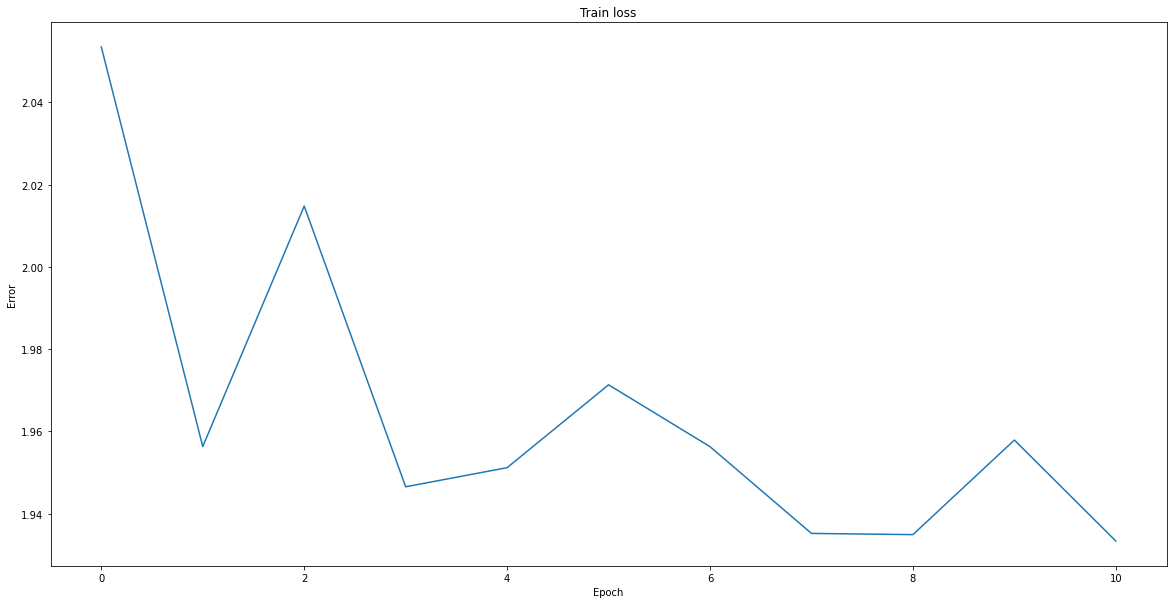

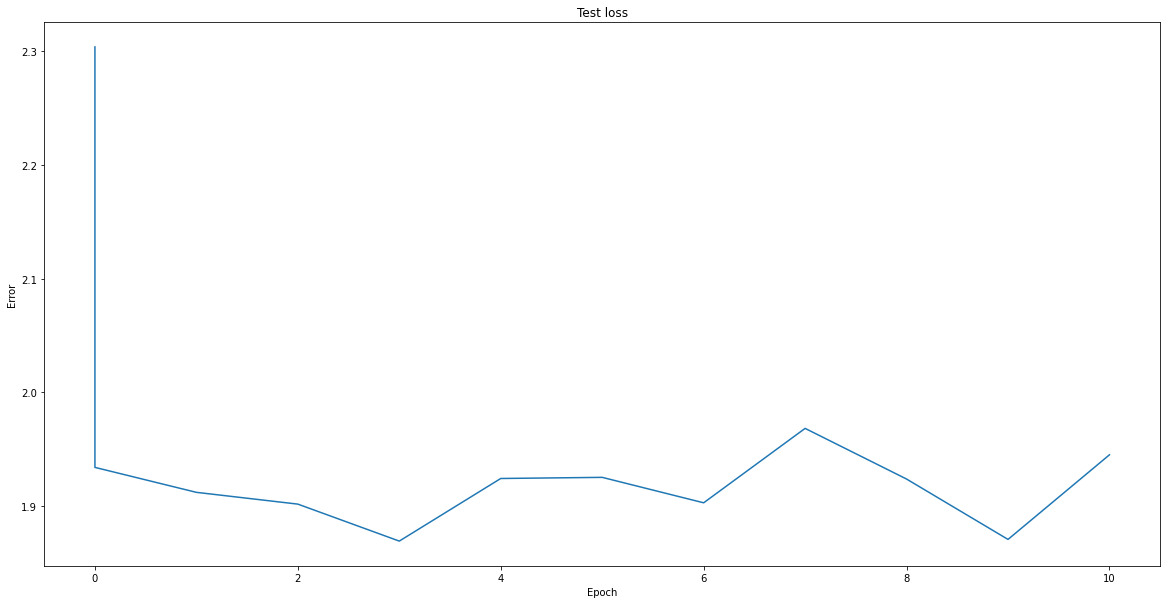

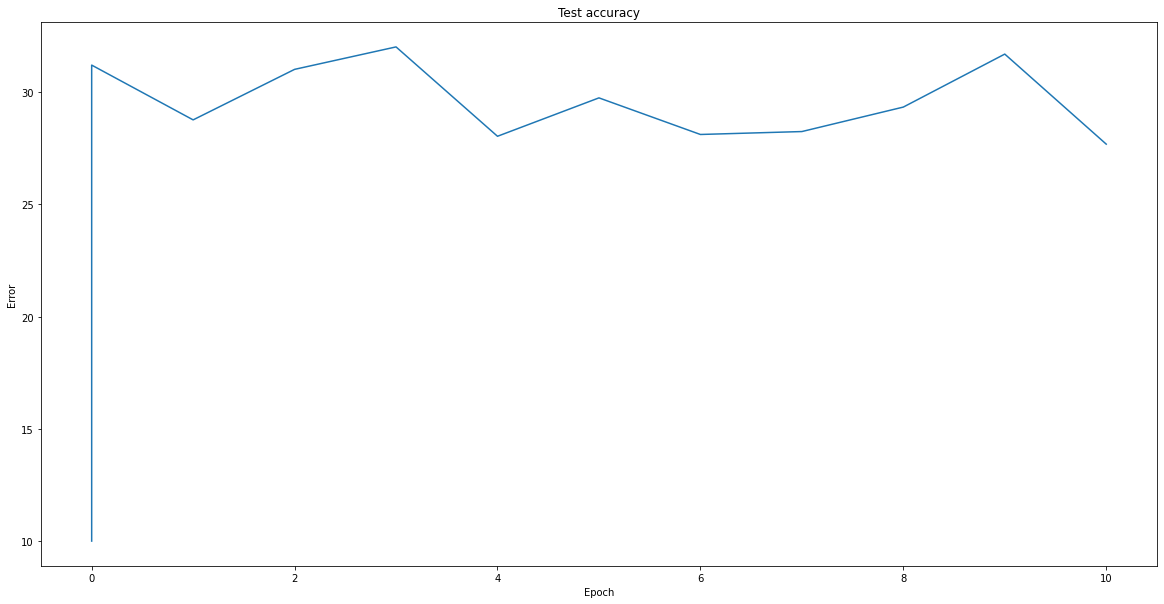

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.2
MOMENTUM = 0.95
USE_CUDA = True
SEED = 10
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0

EXPERIMENT_VERSION = "16.0" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


##CIFAR Questions

1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.


I tried changing most of the hyperparameters and I found that the learning rate is too little and it won't quite converge by the default settings. So, I bumped the LR up 0.06, increased epoch to 30, and reduce the weight decay because I want the network to learn faster at a risk of underfitting. Those values are the best I could find with 63% accuracy. I tried changing the model itself, but the results can by really wild, so I try to find the best parameter for the existing model instead.
```
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.06
MOMENTUM = 0.95
USE_CUDA = True
SEED = 10
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0008
```

2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.

I try to make it super underfitting, so I make the learning rate 0.2 and weight decay 0. I also wanted to make it better than just random (10%), so the result is what I expected, 30% for the maximum accuracy.
```
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.2
MOMENTUM = 0.95
USE_CUDA = True
SEED = 10
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0
```

3. Why do you think the best one worked well and the worst one worked poorly.

Because I tried many possibilies that given the finite epoch, it will converge with a reasonable accuracy. I tried changing for only one parameter while keeping all the others constants and found the rough optimum for each paramters, although it doesn't mean an absolute optimum.
For the worst one, it's really simple because I just need to raise the learning rate and zero the weight decay, so that it will be very underfitting in most cases.


---
# TinyImageNet

## Part 1: Upload the Dataset
Change the DATA_PATH to the path of the TinyImageNet dataset we downloaded earlier.

In [ ]:
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try:

- Maxpooling
- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

To define your network you'll have to figure out more about the Tiny ImageNet dataset. Specifically, what size are the images you'll be processing? How big is your label space? You can find this out by examining samples of your data.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [ ]:
class TinyImagenetNet(nn.Module):
    def __init__(self):
        super(TinyImagenetNet, self).__init__()
        # TODO define the layers
        self.accuracy = None
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        # raise NotImplementedError('Need to define the layers for your network')
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 200)
        )

    def forward(self, x):
        # TODO define the forward pass
        # raise NotImplementedError('Need to define the forward pass')
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy


## Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be accessed a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Hints:
1. HDF5s don't support concurrent accesses.
2. If you don't close the HDF5 file, you will still have problems with concurrency.
3. One way to deal with concurrent accesses is to copy the entirety of the data into each process separately. Then each process accesses its own copy of the data. https://stackoverflow.com/questions/40449659/does-h5py-read-the-whole-file-into-memory
4. Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [ ]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = torch.LongTensor(self.h5_file['labels'][:])
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        data = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)
        return (data, label)


## Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)
print(len(data_test))


100000
8000


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


In [ ]:
!nvidia-smi
!nvcc --version

Fri Nov  5 06:57:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    60W / 149W |   3097MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Using device cuda
num cpus: 2
Restoring:
conv_layer.0.weight -> 	torch.Size([64, 3, 3, 3]) = 0MB
conv_layer.0.bias -> 	torch.Size([64]) = 0MB
conv_layer.1.weight -> 	torch.Size([64]) = 0MB
conv_layer.1.bias -> 	torch.Size([64]) = 0MB
conv_layer.1.running_mean -> 	torch.Size([64]) = 0MB
conv_layer.1.running_var -> 	torch.Size([64]) = 0MB
conv_layer.1.num_batches_tracked -> 	torch.Size([]) = 0MB
conv_layer.4.weight -> 	torch.Size([64, 64, 3, 3]) = 0MB
conv_layer.4.bias -> 	torch.Size([64]) = 0MB
conv_layer.6.weight -> 	torch.Size([64, 64, 3, 3]) = 0MB
conv_layer.6.bias -> 	torch.Size([64]) = 0MB
conv_layer.7.weight -> 	torch.Size([64]) = 0MB
conv_layer.7.bias -> 	torch.Size([64]) = 0MB
conv_layer.7.running_mean -> 	torch.Size([64]) = 0MB
conv_layer.7.running_var -> 	torch.Size([64]) = 0MB
conv_layer.7.num_batches_tracked -> 	torch.Size([]) = 0MB
conv_layer.10.weight -> 	torch.Size([64, 64, 3, 3]) = 0MB
conv_layer.10.bias -> 	torch.Size([64]) = 0MB
conv_layer.13.weight -> 	torch.Size([64,

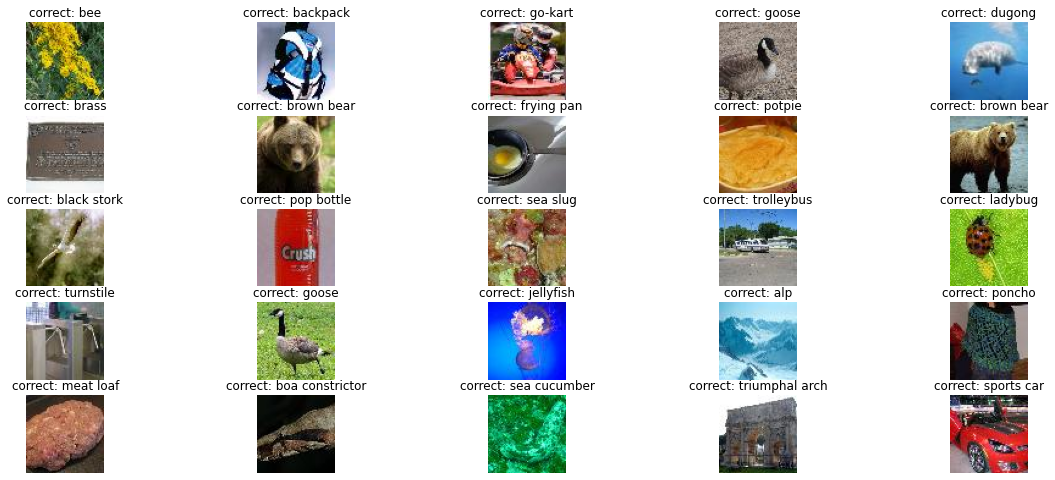

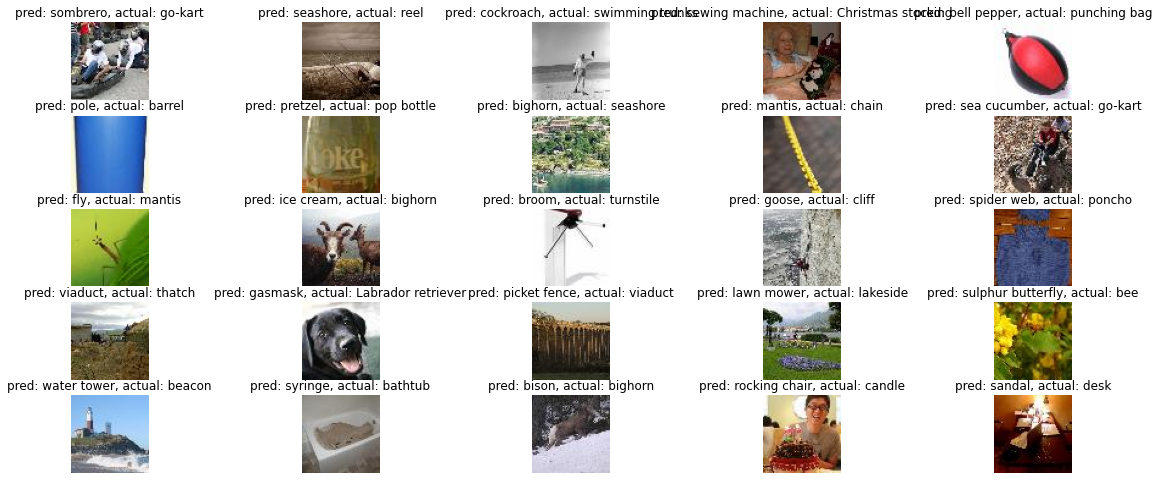

Fri Nov  5 07:48:58 2021 Train Epoch: 83 [0/100000 (0%)]	Loss: 0.061734
Fri Nov  5 07:49:24 2021 Train Epoch: 83 [25600/100000 (26%)]	Loss: 0.018124
Fri Nov  5 07:49:50 2021 Train Epoch: 83 [51200/100000 (51%)]	Loss: 0.037503
Fri Nov  5 07:50:16 2021 Train Epoch: 83 [76800/100000 (77%)]	Loss: 0.042017

Test set: Average loss: 6.0034, Accuracy: 2596/8000 (32%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/14.0/083.pt

Fri Nov  5 07:50:47 2021 Train Epoch: 84 [0/100000 (0%)]	Loss: 0.036442
Fri Nov  5 07:51:13 2021 Train Epoch: 84 [25600/100000 (26%)]	Loss: 0.035810
Fri Nov  5 07:51:39 2021 Train Epoch: 84 [51200/100000 (51%)]	Loss: 0.012331
Fri Nov  5 07:52:05 2021 Train Epoch: 84 [76800/100000 (77%)]	Loss: 0.042995

Test set: Average loss: 6.0112, Accuracy: 2615/8000 (33%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/14.0/084.pt

Fri Nov  5 07:52:35 2021 Train Epoch: 85 [0/100000 (0%)]	Loss: 0.050723
Fri Nov  5 07:53:02 2021 Train Epoch: 85 [25600/100000 (26%)

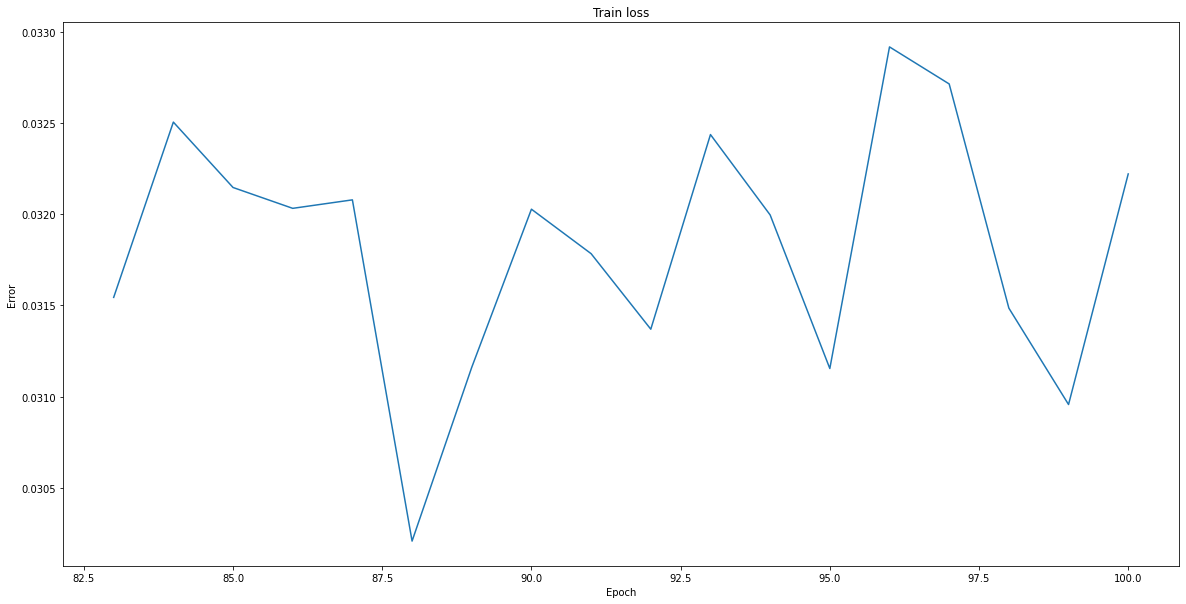

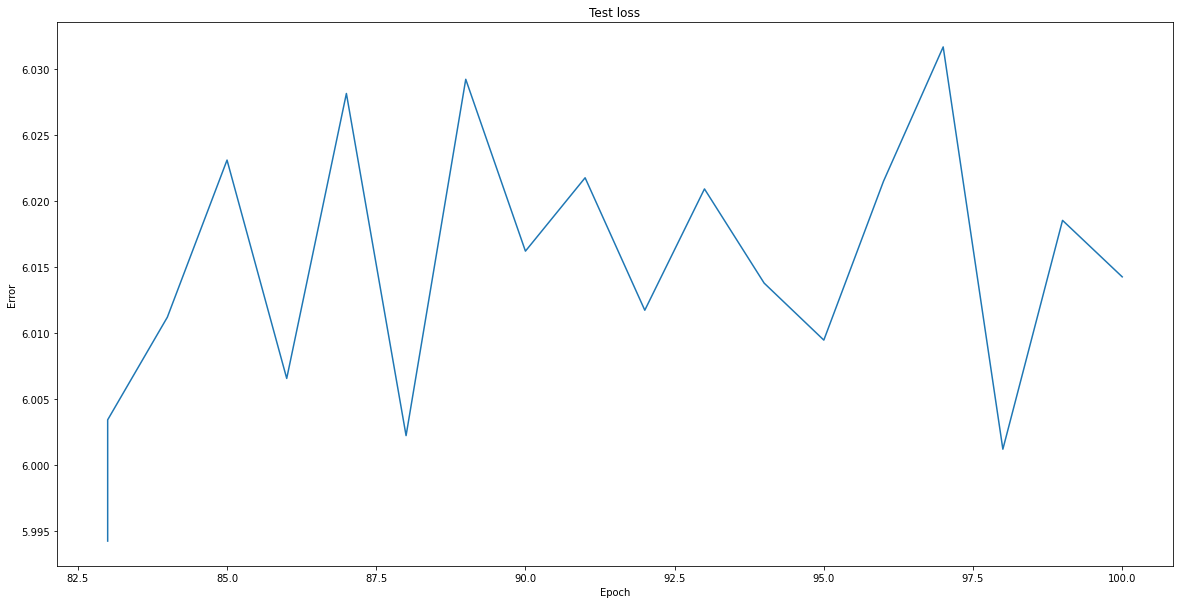

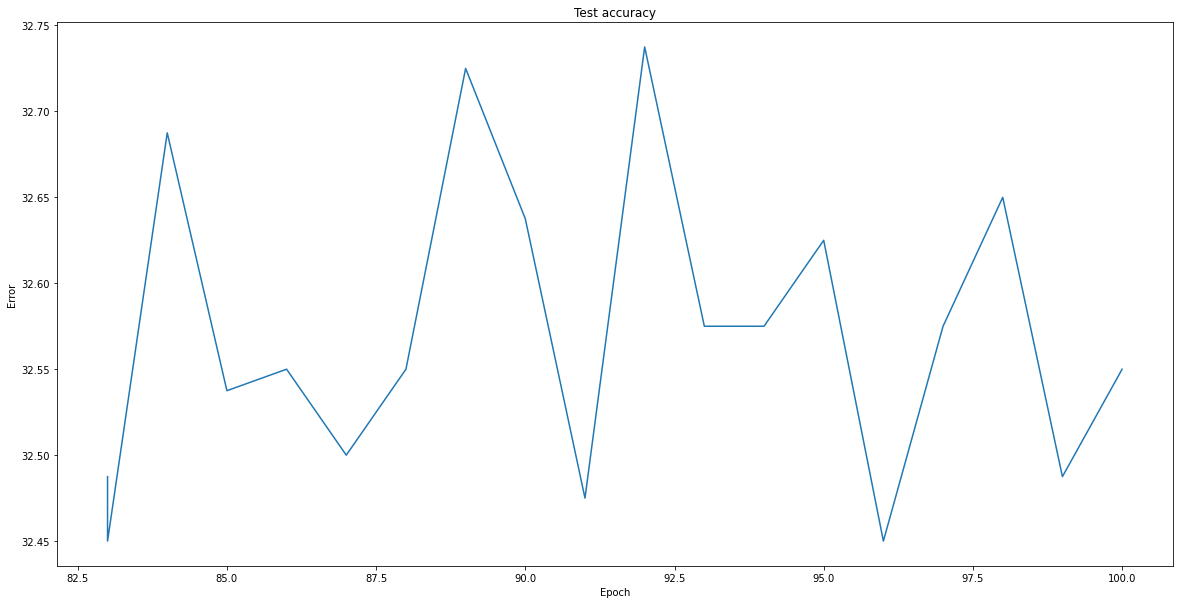

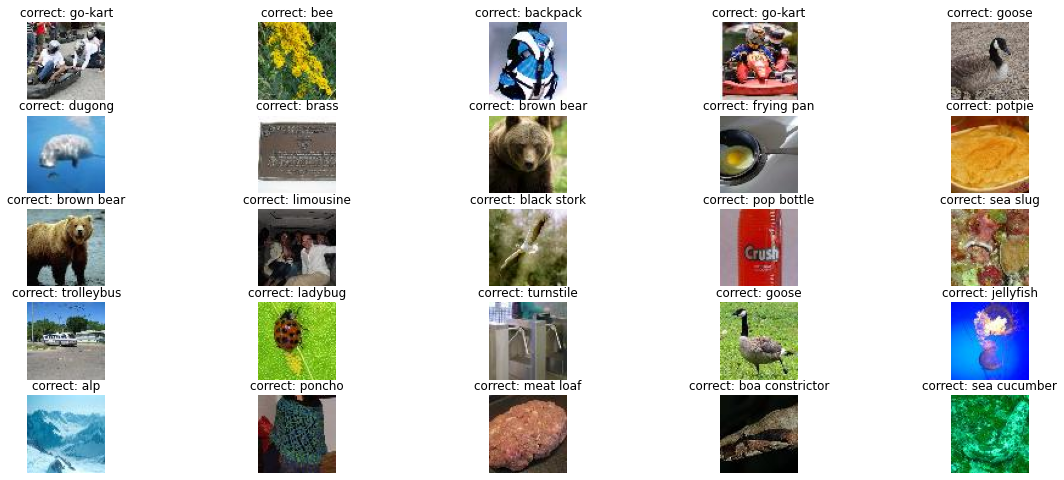

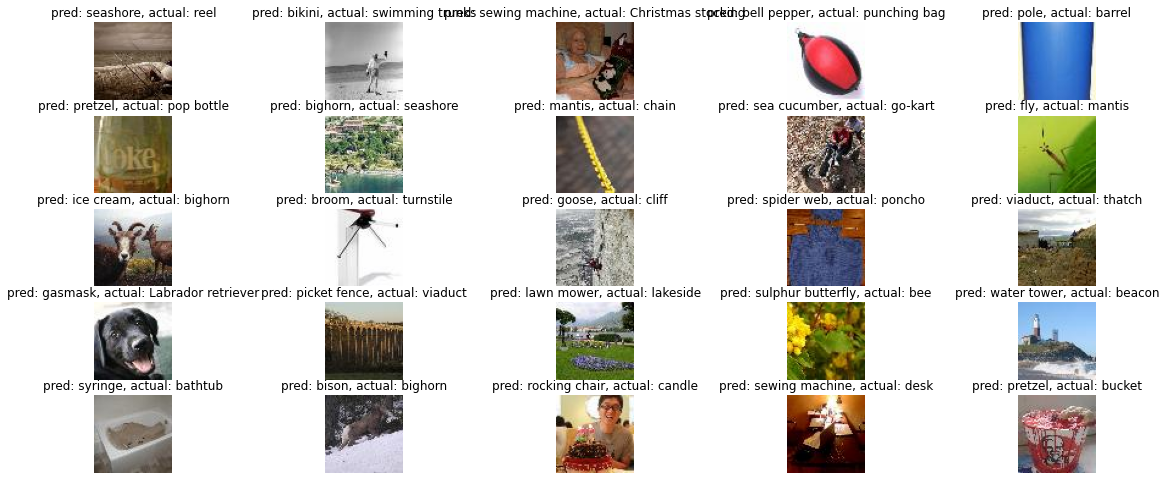

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 0.00001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 20
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "14.0" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


## TinyImageNet Questions

1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from CIFAR question 1.

I tried with a considerably deep convolutional layer with ReLU using bathnorm, maxpool, dropout, and the residual connection techniques after I've done some research on how to make a more efficient network. I didn't change the parameter much but I instead change a lot in in the model. 
```
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 0.00001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 20
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
```
For the image augmentation, I use ToPilImage, randomHorizontalFlip, and normalize them with 0.5 values.

2. Were you able to use larger/deeper networks on TinyImageNet than you used on CIFAR and increase accuracy? If so, why? If not, why not?

Yes, because CIFAR is much simpler than ImageNet and have less classes to classify, and by adding too many layer, it will overfit on the CIFAR. However, we can add much deeper networks on the TinyImageNet because TinyImageNet contains as much as 100,000 images of 200 classes.

3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

If the images are larger, I'd just apply some resizing filters that downsample them to make it simpler for our convoluted network to compute, which is essentially similar to the tiny one. It may lose some details, but classifying an image might not really need a super high resolution. So, I think by applying a filter, it would be faster to converge and doesn't sacrifice much accuracy.
On the other hand, if the image is smaller, I would reduce the number of layers because it might cause overfitting.

# Turn-in

Download your `hw1.ipynb` and put it in your `uwnet` repository.